Travail developpe par le binome :
**Bruno OLIVEIRA, Samuel GHEZI**

Sur orientation de le Professeur **Martin GHIENNE**.

**Introduction**

L’exploitation d’un avion s’accompagne de conditions de vol très variables et difficiles à prédire, ce qui rend complexe l’estimation précise des chargements structuraux rencontrés en situation réelle. Bien que des informations telles que les déformations et les contraintes soient essentielles pour optimiser la maintenance et améliorer les modèles de dimensionnement, ces grandeurs ne sont généralement pas mesurées directement sur les aéronefs commerciaux. L’installation de capteurs dédiés entraînerait en effet une augmentation significative des coûts, de la masse, de la complexité d’intégration et des exigences de certification.

Le Mini-Challenge propose ainsi de développer un capteur virtuel basé sur des méthodes d’apprentissage automatique, capable d’estimer l’état de contrainte structurelle en différents points de l’avion à partir des seuls paramètres déjà enregistrés par l’instrumentation de bord. L’objectif est de prédire des grandeurs non mesurées physiquement, mais inférées à partir de variables de vol telles que l’attitude, les vitesses, les accélérations, les ordres de commande et les conditions de vent.

Pour cela, un ensemble de données réelles provenant de 44 vols d’essai est mis à disposition. Ce jeu de données comprend :

39 paramètres issus de l’instrumentation de bord, représentant l’état de vol, les efforts aérodynamiques et les actions de contrôle ;

15 jauges d’extensométrie (en micro-déformations, με) positionnées en différents points structuraux de l’appareil, permettant de mesurer directement les contraintes locales.

En résumé, ce projet vise à démontrer la capacité d’un modèle d’apprentissage supervisé à reproduire les contraintes structurelles réelles à partir de données opérationnelles courantes, ouvrant la voie à des stratégies de maintenance plus prédictives, moins coûteuses et mieux informées, dans la continuité des travaux précédents sur les capteurs virtuels pour le suivi de santé structurale.

Pour cette projet, on va se baser dans la teorie de Machine Learning, en se basent dans l'image ci dessous :

In [1]:
# Importing Lybraries
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**Management des données** - Acquisition des données

In [2]:
df = pd.read_csv('df.csv')

In [3]:
df = df.drop(columns='Relative_Time')

In [4]:
df.head(10)

,Nz,Nx,Roll_Angle,Pitch_Angle,True_AOA,True_Sideslip,FPA,True_Heading,CAS,TAS,...,Strain7,Strain8,Strain9,Strain10,Strain11,Strain12,Strain13,Strain14,Strain15,Tol_ID
0,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,TOL_1
1,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.823861,0.0,0.0,...,-0.601572,-0.884219,-0.463841,0.161175,-0.000325,-0.143096,0.403351,0.006286,0.175358,TOL_1
2,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.824664,0.0,0.0,...,-0.310433,-1.410038,-1.853289,0.646155,-0.000651,-0.571435,0.818918,0.012573,0.350715,TOL_1
3,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.424748,-1.414549,-1.854326,0.174219,-0.000976,-1.013577,1.216162,-1.045466,-0.521183,TOL_1
4,0.906212,-0.014912,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.572497,-2.114138,2.512348,0.644700,0.579980,-0.572384,1.613406,0.691031,0.003260,TOL_1
5,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,1.025526,-1.238943,3.135614,0.486903,0.579654,-0.572858,1.613664,0.691860,0.004075,TOL_1
6,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825466,0.0,0.0,...,0.289817,-0.374608,1.565383,0.319440,0.579329,-0.577933,1.595600,0.004970,0.004890,TOL_1
7,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826069,0.0,0.0,...,0.879296,0.489727,-0.923224,0.166476,0.572297,-0.576107,-0.181416,-1.214082,-0.517923,TOL_1
8,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.826269,0.0,0.0,...,-0.020616,-1.437107,-0.606083,0.013512,0.578679,-0.574281,0.820468,0.006627,0.006520,TOL_1
9,0.906212,-0.020238,0.147686,-0.311379,3.590025,-2.303673,146.080303,134.825868,0.0,0.0,...,0.434725,0.828243,-0.771030,0.319675,0.578353,-0.577056,0.613072,0.184843,0.181878,TOL_1


In [5]:
# Targets = deformações (saídas do modelo)
target_cols = [f"Strain{i}" for i in range(1, 16)]

# Features = todas as colunas menos Strains e Flight_ID
feature_cols = [c for c in df.columns if c not in target_cols + ["Tol_ID"]]

print("Features:", feature_cols)
print("Targets :", target_cols)

Features: ['Nz', 'Nx', 'Roll_Angle', 'Pitch_Angle', 'True_AOA', 'True_Sideslip', 'FPA', 'True_Heading', 'CAS', 'TAS', 'Mach', 'SAT', 'Baro_Alt', 'Roll_Rate', 'Pitch_Rate', 'Heading_Rate', 'Fuel_Qty1', 'Fuel_Qty2', 'L_Eng_Start', 'R_Eng_Start', 'L_Throttle_Pos', 'R_Throttle_Pos', 'L_Eng_N1', 'R_Eng_N1', 'L_Eng_N2', 'R_Eng_N2', 'L_Gear_Down', 'R_Gear_Down', 'N_Gear_Down', 'L_Flaperon_Pos', 'R_Flaperon_Pos', 'L_LEF_Pos', 'R_LEF_Pos', 'L_Rudder_Pos', 'L_Stab_Pos', 'R_Stab_Pos', 'Stick_Pitch', 'Stick_Roll', 'Pedal_Pos']
Targets : ['Strain1', 'Strain2', 'Strain3', 'Strain4', 'Strain5', 'Strain6', 'Strain7', 'Strain8', 'Strain9', 'Strain10', 'Strain11', 'Strain12', 'Strain13', 'Strain14', 'Strain15']


In [6]:
# Remove linhas com NaN nas colunas importantes
df_clean = df.dropna(subset=feature_cols + target_cols)

X = df_clean[feature_cols].values      # inputs
y = df_clean[target_cols].values      # putputs (strains)
Tol_ids = df_clean["Tol_ID"].values  # TOL related

In [7]:

X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
    X, y, Tol_ids,
    test_size=0.3,
    random_state=42,
    stratify=Tol_ids
)

X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
    X_temp, y_temp, ids_temp,
    test_size=0.5,
    random_state=42,
    stratify=ids_temp
)

In [8]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

In [9]:
class StrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = StrainDataset(X_train_scaled, y_train_scaled)
val_ds   = StrainDataset(X_val_scaled,   y_val_scaled)
test_ds  = StrainDataset(X_test_scaled,  y_test_scaled)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False)

In [10]:
n_features = X_train_scaled.shape[1]
n_outputs  = y_train_scaled.shape[1]   # 15 strains

class StrainMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = StrainMLP().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [11]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in tqdm(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            running_loss += loss.item() * X_batch.size(0)

    return running_loss / len(loader.dataset)

n_epochs = 50

for epoch in range(1, n_epochs + 1):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss   = eval_epoch(model, val_loader, criterion)
    print(f"Epoch {epoch:03d} | Train loss: {train_loss:.6f} | Val loss: {val_loss:.6f}")

100%|██████████| 19303/19303 [01:18<00:00, 247.23it/s]


Epoch 001 | Train loss: 0.131692 | Val loss: 0.093360


100%|██████████| 19303/19303 [01:12<00:00, 265.14it/s]


Epoch 002 | Train loss: 0.083308 | Val loss: 0.079029


100%|██████████| 19303/19303 [01:13<00:00, 263.20it/s]


Epoch 003 | Train loss: 0.069435 | Val loss: 0.065259


100%|██████████| 19303/19303 [01:12<00:00, 265.10it/s]


Epoch 004 | Train loss: 0.062402 | Val loss: 0.059254


100%|██████████| 19303/19303 [01:16<00:00, 251.54it/s]


Epoch 005 | Train loss: 0.057915 | Val loss: 0.055677


100%|██████████| 19303/19303 [01:13<00:00, 264.02it/s]


Epoch 006 | Train loss: 0.054797 | Val loss: 0.052400


100%|██████████| 19303/19303 [01:13<00:00, 261.16it/s]


Epoch 007 | Train loss: 0.052489 | Val loss: 0.050678


100%|██████████| 19303/19303 [01:14<00:00, 257.58it/s]


Epoch 008 | Train loss: 0.050649 | Val loss: 0.050586


100%|██████████| 19303/19303 [01:27<00:00, 219.75it/s]


Epoch 009 | Train loss: 0.049176 | Val loss: 0.049686


100%|██████████| 19303/19303 [01:27<00:00, 220.32it/s]


Epoch 010 | Train loss: 0.047879 | Val loss: 0.048566


100%|██████████| 19303/19303 [01:27<00:00, 221.85it/s]


Epoch 011 | Train loss: 0.046897 | Val loss: 0.046253


100%|██████████| 19303/19303 [01:31<00:00, 210.61it/s]


Epoch 012 | Train loss: 0.045973 | Val loss: 0.046329


100%|██████████| 19303/19303 [01:34<00:00, 203.54it/s]


Epoch 013 | Train loss: 0.045204 | Val loss: 0.045473


100%|██████████| 19303/19303 [01:27<00:00, 220.67it/s]


Epoch 014 | Train loss: 0.044569 | Val loss: 0.044464


100%|██████████| 19303/19303 [01:25<00:00, 225.20it/s]


Epoch 015 | Train loss: 0.043937 | Val loss: 0.043709


100%|██████████| 19303/19303 [01:28<00:00, 217.33it/s]


Epoch 016 | Train loss: 0.043400 | Val loss: 0.043482


100%|██████████| 19303/19303 [01:37<00:00, 198.64it/s]


Epoch 017 | Train loss: 0.042930 | Val loss: 0.042897


100%|██████████| 19303/19303 [01:27<00:00, 220.20it/s]


Epoch 018 | Train loss: 0.042460 | Val loss: 0.042391


100%|██████████| 19303/19303 [01:28<00:00, 217.85it/s]


Epoch 019 | Train loss: 0.042163 | Val loss: 0.042856


100%|██████████| 19303/19303 [01:27<00:00, 221.74it/s]


Epoch 020 | Train loss: 0.041774 | Val loss: 0.041908


100%|██████████| 19303/19303 [01:27<00:00, 219.63it/s]


Epoch 021 | Train loss: 0.041434 | Val loss: 0.042225


100%|██████████| 19303/19303 [01:26<00:00, 223.65it/s]


Epoch 022 | Train loss: 0.041145 | Val loss: 0.040851


100%|██████████| 19303/19303 [01:26<00:00, 223.09it/s]


Epoch 023 | Train loss: 0.040847 | Val loss: 0.040780


100%|██████████| 19303/19303 [01:26<00:00, 224.28it/s]


Epoch 024 | Train loss: 0.040633 | Val loss: 0.042736


100%|██████████| 19303/19303 [01:25<00:00, 225.25it/s]


Epoch 025 | Train loss: 0.040362 | Val loss: 0.040846


100%|██████████| 19303/19303 [01:28<00:00, 217.63it/s]


Epoch 026 | Train loss: 0.040100 | Val loss: 0.040865


100%|██████████| 19303/19303 [01:28<00:00, 218.31it/s]


Epoch 027 | Train loss: 0.039920 | Val loss: 0.040805


100%|██████████| 19303/19303 [01:35<00:00, 202.83it/s]


Epoch 028 | Train loss: 0.039676 | Val loss: 0.042524


100%|██████████| 19303/19303 [01:29<00:00, 215.43it/s]


Epoch 029 | Train loss: 0.039496 | Val loss: 0.040429


100%|██████████| 19303/19303 [01:25<00:00, 224.72it/s]


Epoch 030 | Train loss: 0.039316 | Val loss: 0.040082


100%|██████████| 19303/19303 [01:31<00:00, 212.09it/s]


Epoch 031 | Train loss: 0.039100 | Val loss: 0.040065


100%|██████████| 19303/19303 [01:15<00:00, 255.41it/s]


Epoch 032 | Train loss: 0.038929 | Val loss: 0.039588


100%|██████████| 19303/19303 [01:17<00:00, 249.25it/s]


Epoch 033 | Train loss: 0.038786 | Val loss: 0.040238


100%|██████████| 19303/19303 [01:17<00:00, 248.50it/s]


Epoch 034 | Train loss: 0.038627 | Val loss: 0.040189


100%|██████████| 19303/19303 [01:17<00:00, 247.93it/s]


Epoch 035 | Train loss: 0.038454 | Val loss: 0.038365


100%|██████████| 19303/19303 [01:18<00:00, 245.99it/s]


Epoch 036 | Train loss: 0.038320 | Val loss: 0.038879


100%|██████████| 19303/19303 [01:24<00:00, 227.97it/s]


Epoch 037 | Train loss: 0.038167 | Val loss: 0.039306


100%|██████████| 19303/19303 [01:25<00:00, 225.54it/s]


Epoch 038 | Train loss: 0.038056 | Val loss: 0.038724


100%|██████████| 19303/19303 [01:19<00:00, 243.10it/s]


Epoch 039 | Train loss: 0.037912 | Val loss: 0.038679


100%|██████████| 19303/19303 [01:15<00:00, 256.92it/s]


Epoch 040 | Train loss: 0.037762 | Val loss: 0.039589


100%|██████████| 19303/19303 [01:16<00:00, 252.86it/s]


Epoch 041 | Train loss: 0.037704 | Val loss: 0.038354


100%|██████████| 19303/19303 [01:15<00:00, 255.27it/s]


Epoch 042 | Train loss: 0.037557 | Val loss: 0.040551


100%|██████████| 19303/19303 [01:15<00:00, 256.14it/s]


Epoch 043 | Train loss: 0.037451 | Val loss: 0.037882


100%|██████████| 19303/19303 [01:17<00:00, 249.83it/s]


Epoch 044 | Train loss: 0.037352 | Val loss: 0.038679


100%|██████████| 19303/19303 [01:16<00:00, 252.14it/s]


Epoch 045 | Train loss: 0.037290 | Val loss: 0.037344


100%|██████████| 19303/19303 [01:17<00:00, 248.98it/s]


Epoch 046 | Train loss: 0.037199 | Val loss: 0.037170


100%|██████████| 19303/19303 [01:15<00:00, 254.97it/s]


Epoch 047 | Train loss: 0.037100 | Val loss: 0.038225


100%|██████████| 19303/19303 [01:18<00:00, 246.22it/s]


Epoch 048 | Train loss: 0.037011 | Val loss: 0.038173


100%|██████████| 19303/19303 [01:28<00:00, 218.11it/s]


Epoch 049 | Train loss: 0.036935 | Val loss: 0.037403


100%|██████████| 19303/19303 [01:31<00:00, 211.67it/s]


Epoch 050 | Train loss: 0.036797 | Val loss: 0.037097


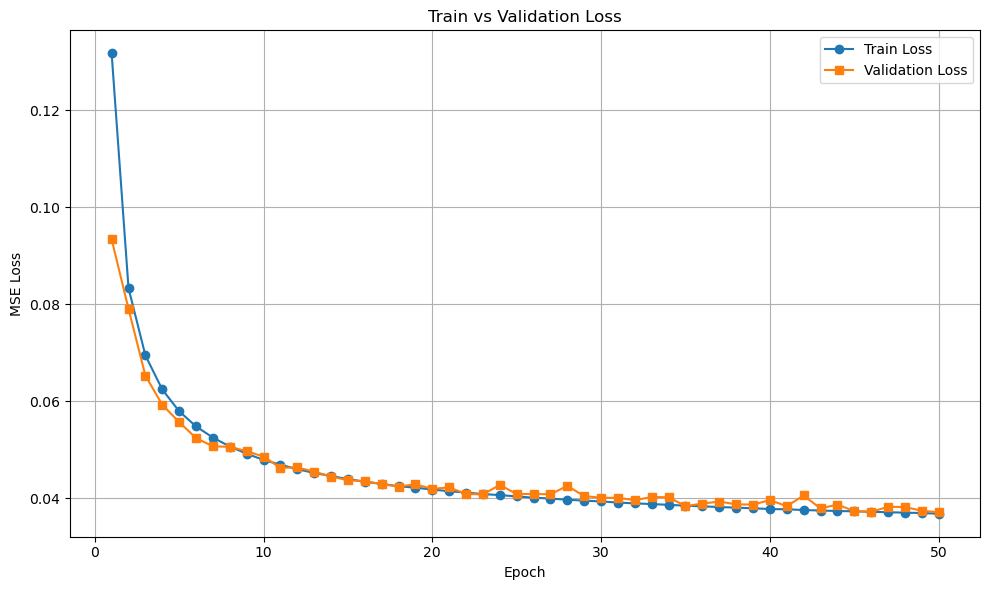

In [12]:
train_losses = [
0.131692, 0.083308, 0.069435, 0.062402, 0.057915,
0.054797, 0.052489, 0.050649, 0.049176, 0.047879,
0.046897, 0.045973, 0.045204, 0.044569, 0.043937,
0.043400, 0.042930, 0.042460, 0.042163, 0.041774,
0.041434, 0.041145, 0.040847, 0.040633, 0.040362,
0.040100, 0.039920, 0.039676, 0.039496, 0.039316,
0.039100, 0.038929, 0.038786, 0.038627, 0.038454,
0.038320, 0.038167, 0.038056, 0.037912, 0.037762,
0.037704, 0.037557, 0.037451, 0.037352, 0.037290,
0.037199, 0.037100, 0.037011, 0.036935, 0.036797
]

val_losses = [
0.093360, 0.079029, 0.065259, 0.059254, 0.055677,
0.052400, 0.050678, 0.050586, 0.049686, 0.048566,
0.046253, 0.046329, 0.045473, 0.044464, 0.043709,
0.043482, 0.042897, 0.042391, 0.042856, 0.041908,
0.042225, 0.040851, 0.040780, 0.042736, 0.040846,
0.040865, 0.040805, 0.042524, 0.040429, 0.040082,
0.040065, 0.039588, 0.040238, 0.040189, 0.038365,
0.038879, 0.039306, 0.038724, 0.038679, 0.039589,
0.038354, 0.040551, 0.037882, 0.038679, 0.037344,
0.037170, 0.038225, 0.038173, 0.037403, 0.037097
]



plt.figure(figsize=(10,6))

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses,   label="Validation Loss", marker='s')

plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss")
plt.grid(True)
plt.legend()
plt.savefig('Train_vs_Validation_Loss.png', dpi=300)
plt.tight_layout()
plt.show()


In [ ]:
img = mpimg.imread("Train_vs_Validation_Loss.png")

plt.figure(figsize=(12, 10))
plt.imshow(img)
plt.axis("off")
plt.show()

lire les images de le training up side

In [13]:
model.eval()
with torch.no_grad():
    X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
    y_pred_scaled = model(X_test_t).cpu().numpy()

# # voltar para escala original das strains
# y_test_real = scaler_y.inverse_transform(y_test)
# y_pred_real = scaler_y.inverse_transform(y_pred_scaled)

y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test_scaled)

# métricas globais
mae_global  = mean_absolute_error(y_test_real, y_pred_real)
rmse_global = mean_squared_error(y_test_real, y_pred_real, squared=False)
r2_global   = r2_score(y_test_real, y_pred_real)

print("Overall metrics in the test set:")
print(f"MAE  : {mae_global:.4f}")
print(f"RMSE : {rmse_global:.4f}")
print(f"R²   : {r2_global:.4f}")

Overall metrics in the test set:
MAE  : 19.9036
RMSE : 30.5124
R²   : 0.9628


In [14]:
metrics_per_flight = {}
unique_flights = np.unique(ids_test)

for flight in unique_flights:
    mask = (ids_test == flight)
    y_true_f = y_test_real[mask]
    y_pred_f = y_pred_real[mask]

    mae  = mean_absolute_error(y_true_f, y_pred_f)
    rmse = mean_squared_error(y_true_f, y_pred_f, squared=False)
    r2   = r2_score(y_true_f, y_pred_f)

    metrics_per_flight[flight] = {"MAE": mae, "RMSE": rmse, "R2": r2}

for flight, m in metrics_per_flight.items():
    print(f"{flight}: MAE={m['MAE']:.4f}, RMSE={m['RMSE']:.4f}, R²={m['R2']:.4f}")

mae_mean  = np.mean([m["MAE"]  for m in metrics_per_flight.values()])
rmse_mean = np.mean([m["RMSE"] for m in metrics_per_flight.values()])
r2_mean   = np.mean([m["R2"]   for m in metrics_per_flight.values()])

print("\nAverage metrics across all TOLs (test):")
print(f"MAE médio  : {mae_mean:.4f}")
print(f"RMSE médio : {rmse_mean:.4f}")
print(f"R² médio   : {r2_mean:.4f}")

TOL_1: MAE=17.2699, RMSE=25.2152, R²=0.9672
TOL_10: MAE=18.0366, RMSE=26.1755, R²=0.9383
TOL_11: MAE=18.8595, RMSE=29.6737, R²=0.9328
TOL_12: MAE=23.1074, RMSE=35.2662, R²=0.9302
TOL_13: MAE=19.4904, RMSE=26.3868, R²=0.9537
TOL_14: MAE=22.9576, RMSE=34.9034, R²=0.9470
TOL_15: MAE=24.6398, RMSE=36.3449, R²=0.9478
TOL_17: MAE=18.9167, RMSE=26.4841, R²=0.9585
TOL_18: MAE=24.7793, RMSE=39.4812, R²=0.9207
TOL_19: MAE=19.9265, RMSE=30.7679, R²=0.9370
TOL_2: MAE=15.6402, RMSE=23.0699, R²=0.9483
TOL_20: MAE=24.0251, RMSE=34.7997, R²=0.9323
TOL_21: MAE=17.0795, RMSE=25.3150, R²=0.9617
TOL_22: MAE=14.3607, RMSE=19.8138, R²=0.8980
TOL_23: MAE=17.1537, RMSE=27.2600, R²=0.9319
TOL_24: MAE=17.3238, RMSE=24.9202, R²=0.9417
TOL_25: MAE=17.1161, RMSE=25.1042, R²=0.9645
TOL_26: MAE=22.5700, RMSE=36.3205, R²=0.9527
TOL_27: MAE=19.9527, RMSE=29.4973, R²=0.9051
TOL_28: MAE=20.9719, RMSE=32.1533, R²=0.9331
TOL_29: MAE=20.5433, RMSE=30.8123, R²=0.9357
TOL_3: MAE=14.3526, RMSE=20.0619, R²=0.9688
TOL_30: MAE=1

In [15]:
df_flights = pd.DataFrame.from_dict(metrics_per_flight, orient='index')

# adicionar as métricas globais
df_global = pd.DataFrame({
    "MAE":  [mae_global],
    "RMSE": [rmse_global],
    "R2":   [r2_global]
}, index=["GLOBAL"])

# concatenar tudo
df_results = pd.concat([df_flights, df_global])



In [16]:
df_results.to_csv('df_results_all_50epch.csv')

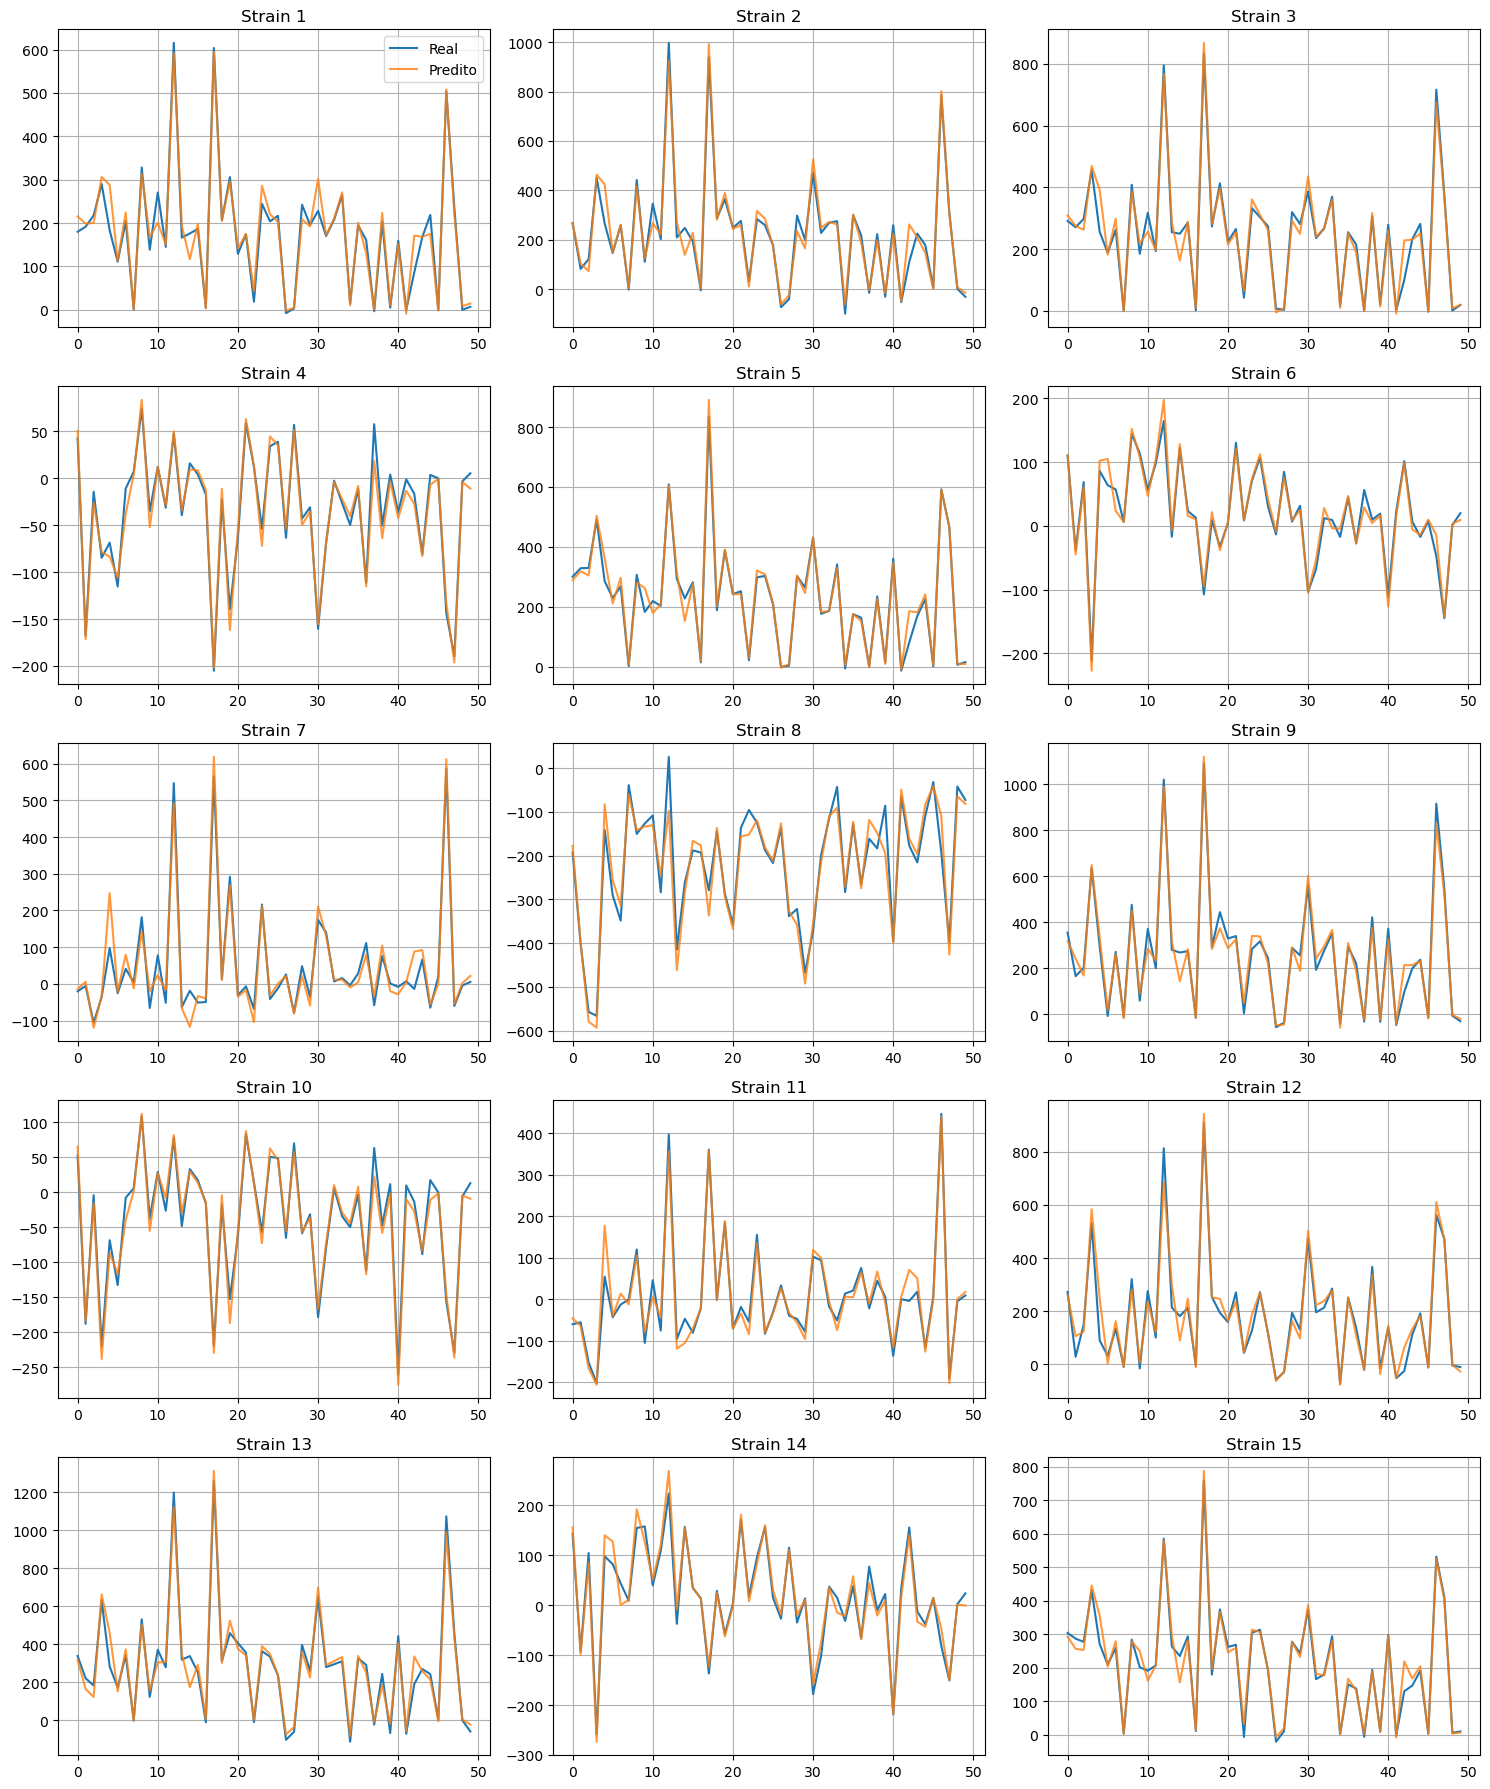

In [18]:
N = 50  # Number of point in the x axis

plt.figure(figsize=(15, 18))

for i in range(15):
    plt.subplot(5, 3, i + 1)
    plt.plot(y_test_real[:N, i], label="Real")
    plt.plot(y_pred_real[:N, i], label="Predito", alpha=0.8)
    plt.title(f"Strain {i+1}")
    plt.grid(True)
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()